In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Develop CNN and Resnet50

### Importing Libraries

In [43]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Loading the dataset

In [3]:
train_data_dir = '/content/drive/My Drive/Week5Portfolio/TrainSet'
test_data_dir = '/content/drive/My Drive/Week5Portfolio/TestSet'
# Load the Train and Test dataset
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    image_size=(32, 32),  # Resize images to 32x32
    batch_size=32,
    label_mode='int'  # Labels will be integers (0 and 1)
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_data_dir,
    image_size=(32, 32),  # Resize images to 32x32
    batch_size=32,
    label_mode='int'  # Labels will be integers (0 and 1)
)

Found 750 files belonging to 2 classes.
Found 20 files belonging to 2 classes.


In [4]:
class_names = train_dataset.class_names
print("Class Names:", class_names)
# Display mapping of label to class
for i, class_name in enumerate(class_names):
    print(f"Label {i}: {class_name}")

Class Names: ['NoRust', 'Rust']
Label 0: NoRust
Label 1: Rust


### Build and test a simple CNN Model



In [5]:
simpleCNN = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(2, activation='softmax')  # 2 classes
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [6]:
# Compile the model
simpleCNN.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Train the model
history = simpleCNN.fit(train_dataset, epochs=10)

Epoch 1/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - accuracy: 0.5572 - loss: 13.3067
Epoch 2/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.6517 - loss: 0.6709
Epoch 3/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 269ms/step - accuracy: 0.7083 - loss: 0.5990
Epoch 4/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.7378 - loss: 0.5549
Epoch 5/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 6s 256ms/step - accuracy: 0.7494 - loss: 0.5381
Epoch 6/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 291ms/step - accuracy: 0.7781 - loss: 0.4670
Epoch 7/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.7862 - loss: 0.4520
Epoch 8/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 191ms/step - accuracy: 0.8146 - loss: 0.4553
Epoch 9/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 7s 279ms/step - accuracy: 0.8116 - loss: 0.4653
Epoch 10/10
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 189ms/step - accuracy: 0.7955 - loss: 0.4590


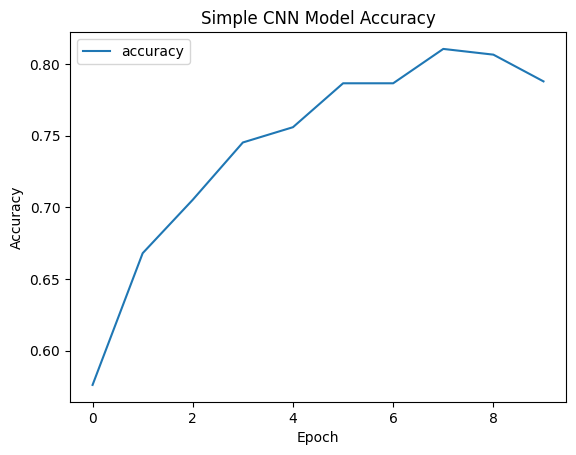

In [8]:
# Plot training accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Simple CNN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Make a prediction and save results

In [9]:
# Make predictions
test_loss, test_acc = simpleCNN.evaluate(test_dataset, verbose=0)  # Set verbose to 0 to suppress output
print('Test accuracy:', test_acc)

Test accuracy: 0.699999988079071


In [44]:
predictions = simpleCNN.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1).numpy()  # Get predicted class indices
# Get true labels
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())  # Convert tensor to numpy array
true_labels = np.array(true_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step


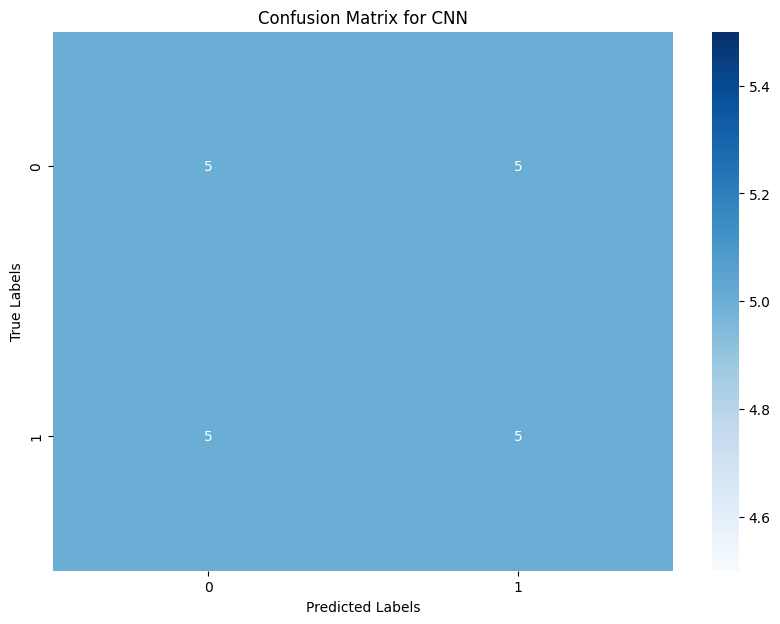

In [46]:
conf_matrix = confusion_matrix(true_labels, predicted_classes)
# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for CNN')
plt.show()

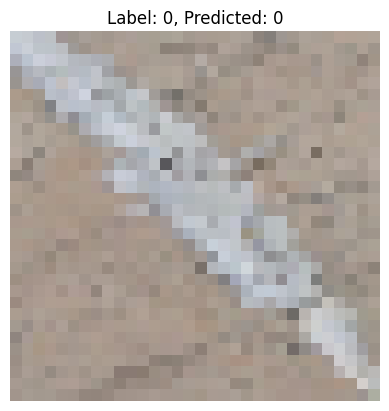

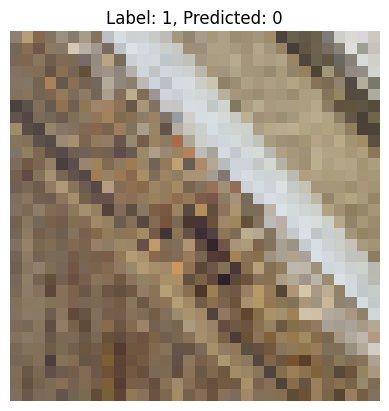

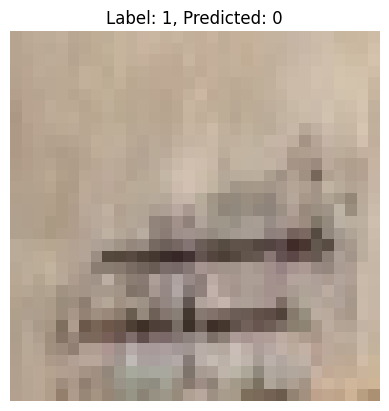

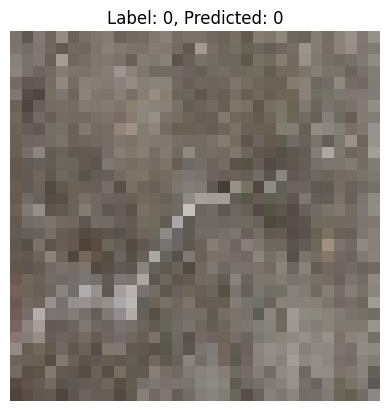

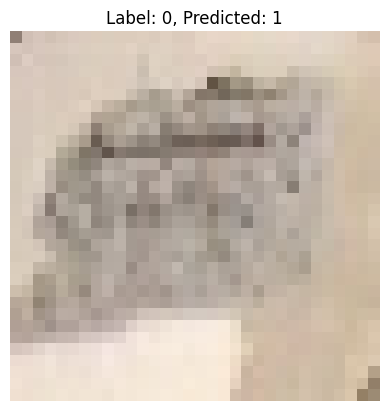

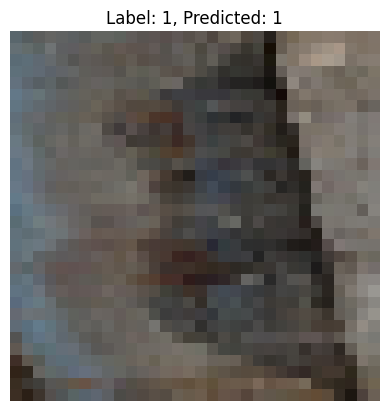

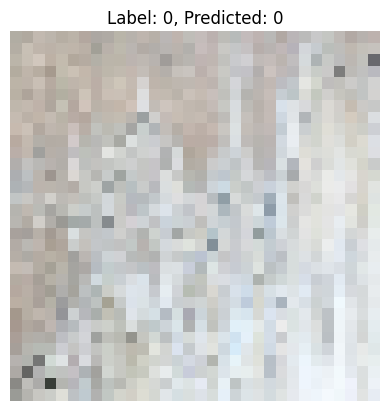

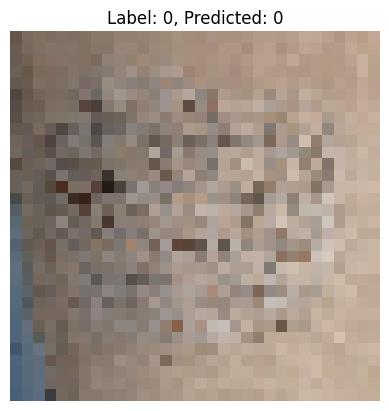

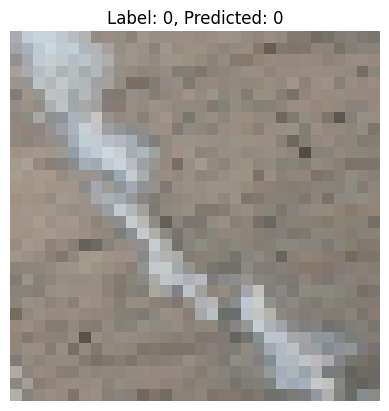

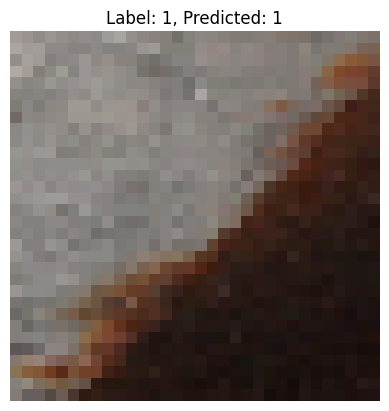

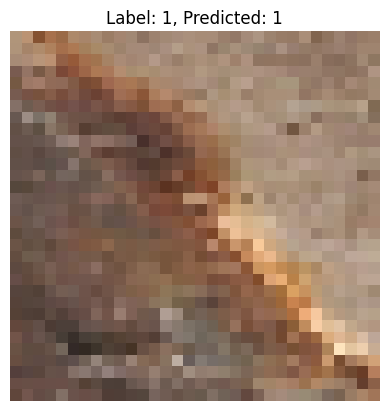

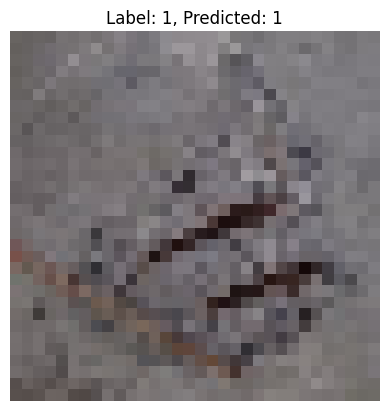

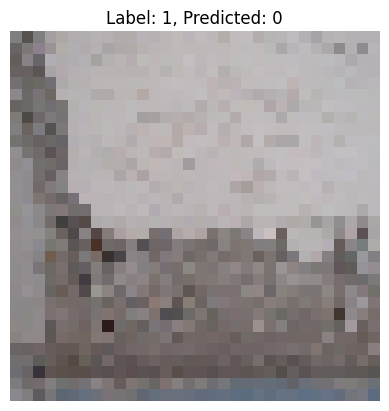

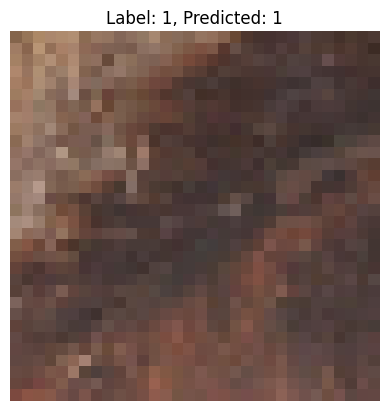

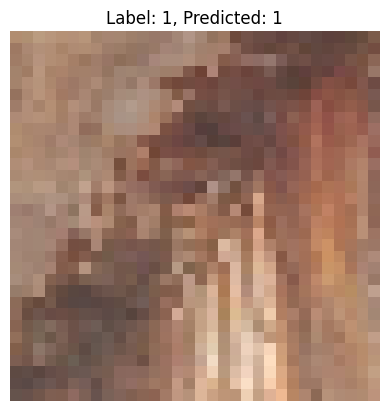

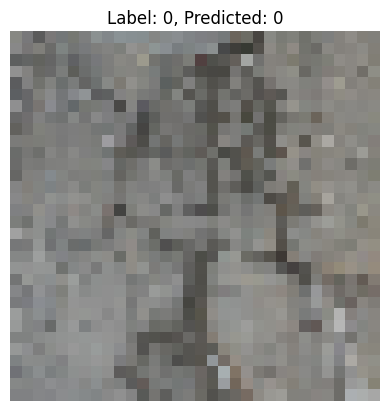

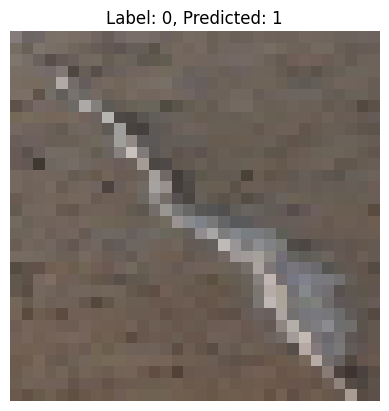

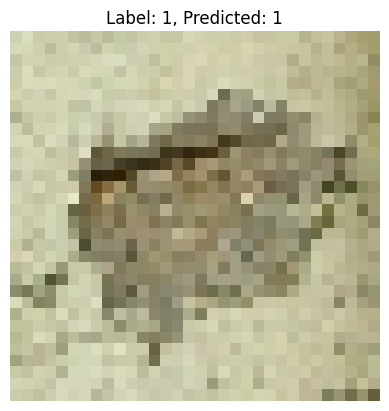

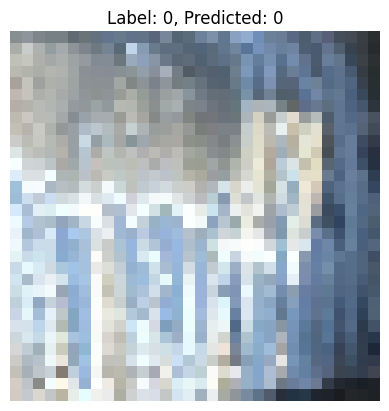

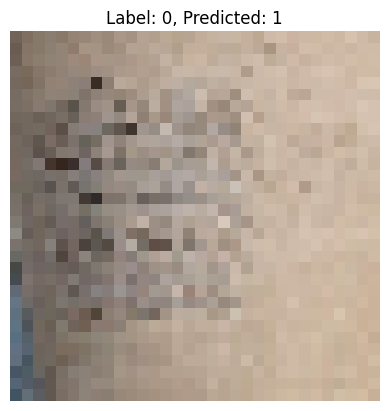

In [37]:
simpleCNN_output_dir="/content/drive/My Drive/Week5Portfolio/Task1Result/SimpleCNN"
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for display
        plt.title(f'Label: {labels[i].numpy()}, Predicted: {predicted_classes[i]}')  # Show the label
        plt.axis('off')  # Hide axes
        output_path = os.path.join(simpleCNN_output_dir, f'image_{i}.png')
        plt.savefig(output_path)
        plt.show()


### CNN + ResNet

In [38]:
# Load the ResNet50 model with pre-trained weights
ResNet50Base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the base model
ResNet50Base.trainable = False

# Create the full model
model = models.Sequential([
    ResNet50Base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Adjust for number of classes
])

# Create the full model
myModel = models.Sequential([
    ResNet50Base,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_dataset.class_names), activation='softmax')  # Adjust for number of classes
])

# Compile the model
myModel.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = myModel.fit(train_dataset, epochs=20)  # Adjust epochs as necessary

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 326ms/step - accuracy: 0.6288 - loss: 1.3180
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 14s 496ms/step - accuracy: 0.8813 - loss: 0.2607
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 17s 339ms/step - accuracy: 0.9731 - loss: 0.1244
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 390ms/step - accuracy: 0.9878 - loss: 0.0735
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 286ms/step - accuracy: 0.9953 - loss: 0.0422
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 345ms/step - accuracy: 0.9977 - loss: 0.0311
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 10s 348ms/step - accuracy: 0.9993 - loss: 0.0198
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.9997 - loss: 0.0162
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 318ms/step - accuracy: 0.9997 - loss: 0.0122
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 11s 382ms/step - accuracy: 0.9992 - loss: 0.0096
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 304ms/step - accuracy: 0.9989 - loss: 0

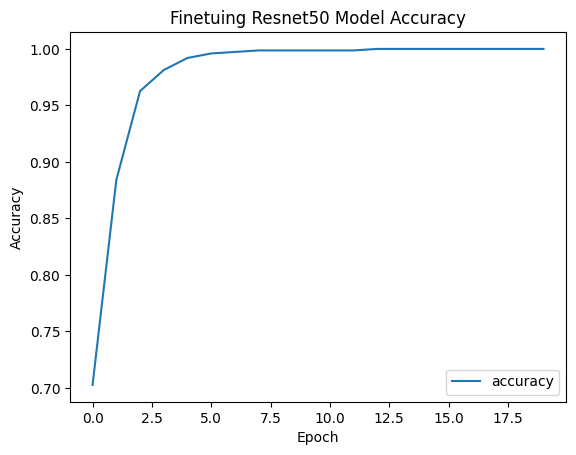

In [39]:
# Plot training accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.title('Finetuing Resnet50 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

#### Make a prediction and save results

In [40]:
# Make predictions
test_loss, test_acc = myModel.evaluate(test_dataset, verbose=0)  # Set verbose to 0 to suppress output
print('Test accuracy:', test_acc)

Test accuracy: 0.699999988079071


In [47]:
predictions = myModel.predict(test_dataset)
predicted_classes = tf.argmax(predictions, axis=1).numpy()  # Get predicted class indices
# Get true labels
true_labels = []
for images, labels in test_dataset:
    true_labels.extend(labels.numpy())  # Convert tensor to numpy array
true_labels = np.array(true_labels)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


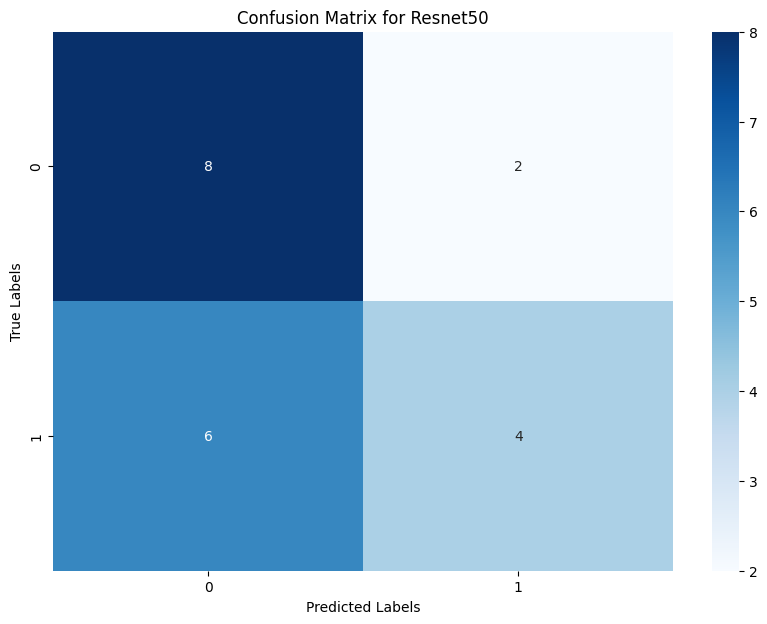

In [48]:
conf_matrix = confusion_matrix(true_labels, predicted_classes)
# Visualize the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(true_labels), yticklabels=np.unique(true_labels))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix for Resnet50')
plt.show()

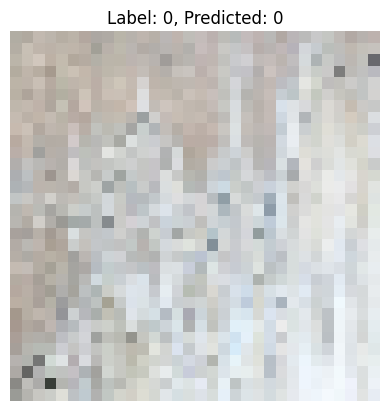

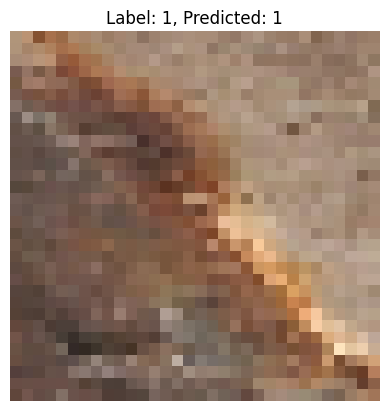

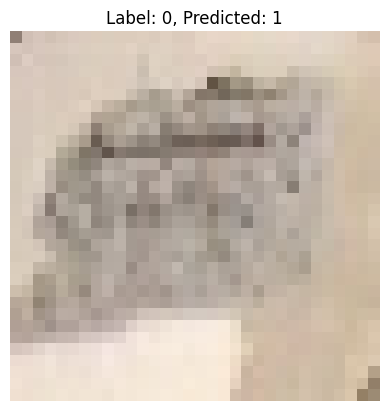

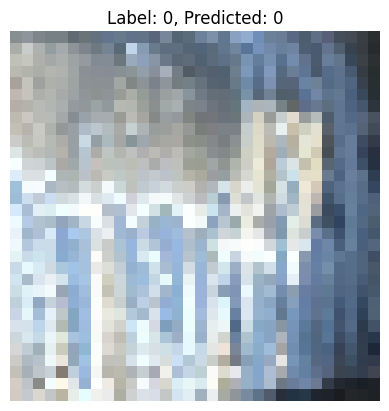

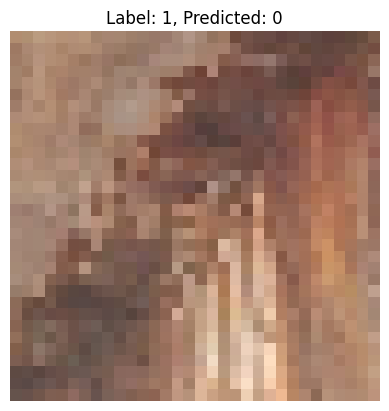

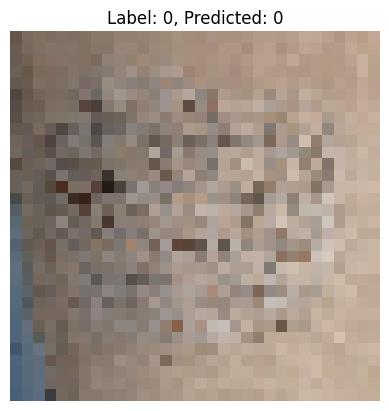

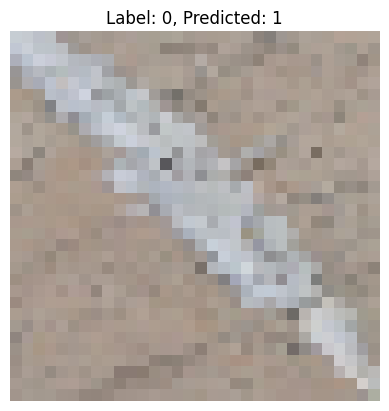

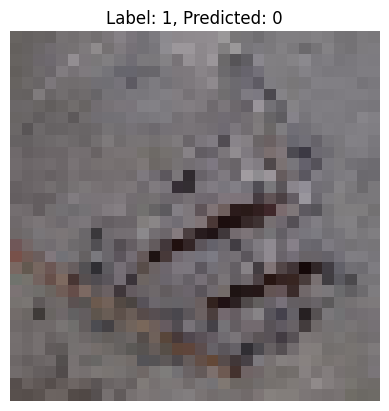

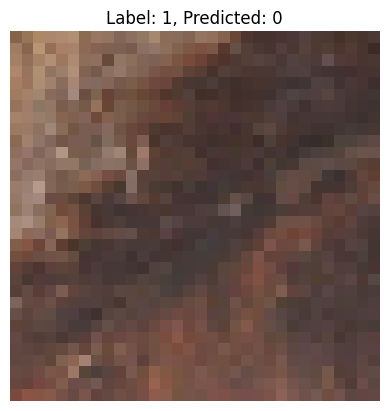

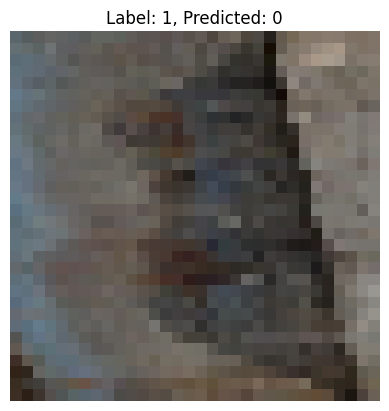

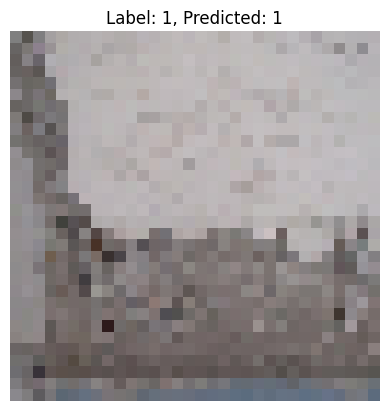

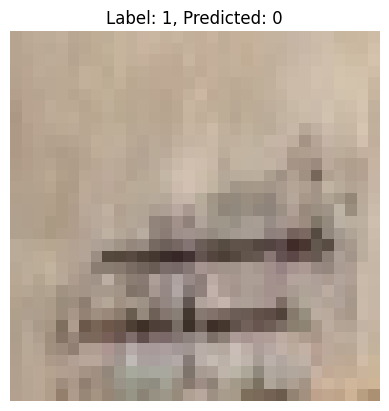

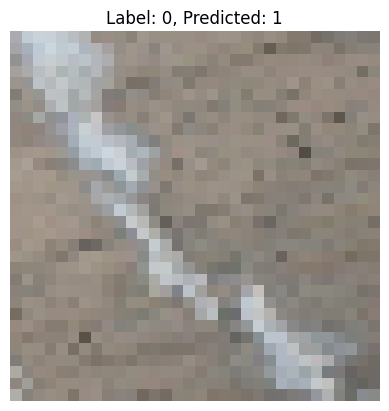

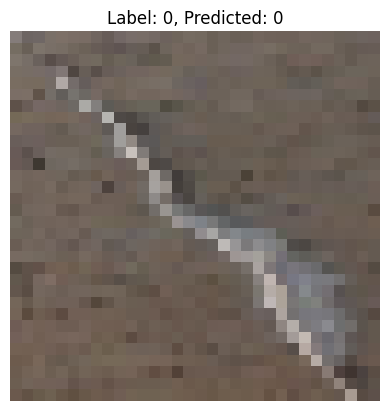

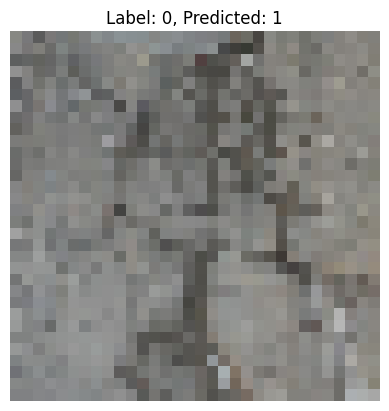

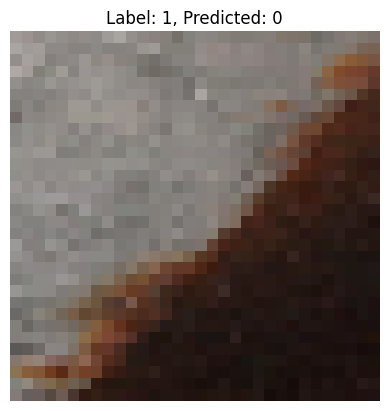

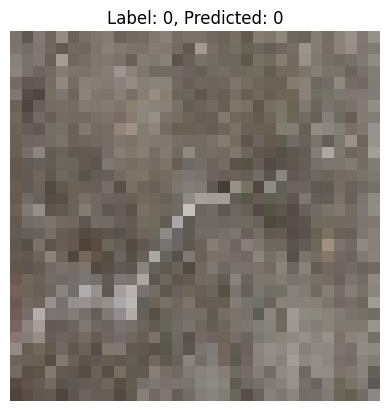

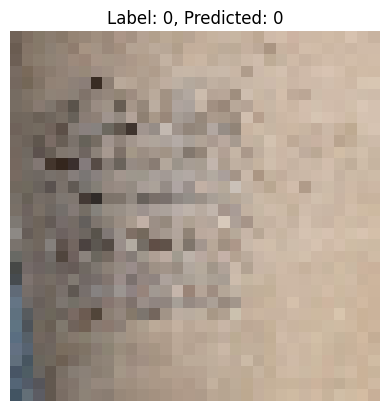

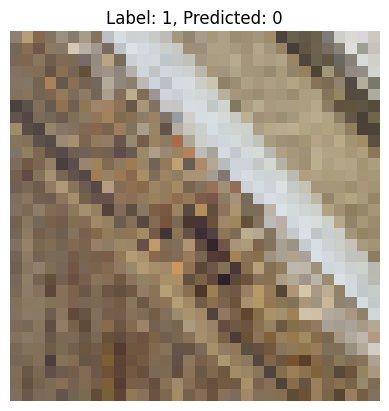

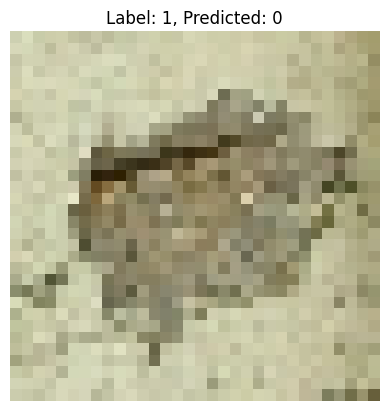

In [42]:
restnet50_output_dir="/content/drive/My Drive/Week5Portfolio/Task1Result/Restnet50"
for images, labels in test_dataset:
    for i in range(images.shape[0]):
        plt.imshow(images[i].numpy().astype("uint8"))  # Convert to uint8 for display
        plt.title(f'Label: {labels[i].numpy()}, Predicted: {predicted_classes[i]}')  # Show the label
        plt.axis('off')  # Hide axes
        output_path = os.path.join(simpleCNN_output_dir, f'image_{i}.png')
        plt.savefig(output_path)
        plt.show()

# Task 2: Develop Mask RCNN for detecting log

### Convert to Coco

In [1]:
%pip install labelme2coco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 113.6/113.6 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 10.3 MB/s eta 0:00:00
  Created wheel for fire: filename=fire-0.7.0-py3-none-any.whl size=114250 sha256=0aba3c80b6ec8efaf28ccc8123307fec616512b8021c9e977ccf1af839e9228d
  Stored in directory: /root/.cache/pip/wheels/19/39/2f/2d3cadc408a8804103f1c34ddd4b9f6a93497b11fa96fe738e
Successfully built fire
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.10.0.84
    Uninstalling opencv-python-4.10.0.84:
      Successfully uninstalled opencv-python-4.10.0.84


#### Converting training dataset

In [3]:
import labelme2coco

train_data_dir = '/content/drive/My Drive/Week5Portfolio/log-labelled'
label_train_data_dir = '/content/drive/My Drive/Week5Portfolio/log-labelled-converted'

labelme2coco.convert(train_data_dir, label_train_data_dir)

There are 590 listed files in folder log-labelled.


Converting labelme annotations to COCO format: 100%|██████████| 590/590 [01:33<00:00,  6.32it/s]


#### Converting Testing Dataset

In [6]:
# set path for coco json to be saved
test_data_dir="/content/drive/My Drive/Week5Portfolio/Task2TestSet"

# set path for coco json to be saved
label_test_data_dir = "/content/drive/My Drive/Week5Portfolio/Task2TestSet_converted"

labelme2coco.convert(test_data_dir, label_test_data_dir)

There are 10 listed files in folder Task2TestSet.


Converting labelme annotations to COCO format: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


### Load Training Dataset

In [3]:
import json
import os
import numpy as np
import tensorflow as tf
from PIL import Image

class CocoDataset(tf.keras.utils.Sequence):
    def __init__(self, json_file, images_folder, batch_size=32, image_size=(224, 224)):
        self.json_file = json_file
        self.images_folder = images_folder
        self.batch_size = batch_size
        self.image_size = image_size
        self.annotations = self.load_annotations()
        self.image_ids = list(self.annotations.keys())

    def load_annotations(self):
        with open(self.json_file) as f:
            data = json.load(f)
        annotations = {image['id']: [] for image in data['images']}
        for ann in data['annotations']:
            annotations[ann['image_id']].append(ann['bbox'])
        return annotations

    def __len__(self):
        return int(np.ceil(len(self.image_ids) / self.batch_size))

    def __getitem__(self, idx):
        batch_ids = self.image_ids[idx * self.batch_size:(idx + 1) * self.batch_size]
        images = []
        bboxes = []

        for img_id in batch_ids:
            img_info = self.annotations[img_id]
            image_path = os.path.join(self.images_folder, img_info['file_name'])
            image = Image.open(image_path).resize(self.image_size)
            image = np.array(image) / 255.0  # Normalize to [0, 1]
            images.append(image)

            # Collect bounding boxes for this image
            boxes = img_info if img_id in self.annotations else []
            bboxes.append(np.array(boxes))

        return np.array(images), np.array(bboxes)

In [4]:
label_json_file = '/content/drive/My Drive/Week5Portfolio/log-labelled-converted/dataset.json'  # Path to your JSON file
training_images_folder = '/content/drive/My Drive/Week5Portfolio/log-labelled'   # Folder containing images
batch_size = 16
image_size = (224, 224)

training_dataset = CocoDataset(label_json_file, training_images_folder, batch_size=batch_size, image_size=image_size)

In [5]:
training_dataset = tf.data.Dataset.from_generator(
    lambda: training_dataset,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, None, 4), dtype=tf.float32)
    )
)


#### Define mask RCNN

In [6]:
def build_backbone(input_shape):
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False)
    return base_model

def create_mask_rcnn_single_class_model(input_shape):
    inputs = layers.Input(shape=input_shape)

    # Backbone for feature extraction
    backbone = build_backbone(input_shape)
    feature_maps = backbone(inputs)

    # Region Proposal Network (RPN)
    rpn_output = layers.Conv2D(512, (3, 3), padding='same', activation='relu')(feature_maps)
    rpn_class = layers.Conv2D(1, (1, 1), activation='sigmoid')(rpn_output)  # Single class
    rpn_box = layers.Conv2D(4, (1, 1))(rpn_output)  # 4 coordinates for bounding boxes

    # Classifier and BBox regressor without additional classes
    classifier_output = layers.Dense(1, activation='sigmoid')(feature_maps)  # Single class output
    box_output = layers.Dense(4)(feature_maps)  # 4 for bounding box

    # Mask branch (for single class)
    mask_output = layers.Conv2D(1, (1, 1), activation='sigmoid')(feature_maps)  # Single mask

    # Combine outputs
    model = Model(inputs, [rpn_class, rpn_box, classifier_output, box_output, mask_output])
    return model

In [7]:
input_shape = (224, 224, 3)  # Variable input size for flexibility

mask_rcnn_model = create_mask_rcnn_single_class_model(input_shape)
mask_rcnn_model.compile(optimizer='adam',
                        loss=['binary_crossentropy', 'mse', 'binary_crossentropy', 'mse', 'binary_crossentropy'],
                        metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [9]:
mask_rcnn_model.fit(training_dataset, epochs=10)  # Adjust epochs as needed

Epoch 1/10


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, None, 4), output.shape=(None, 7, 7)